In [1]:
import os
import pcse
import yaml
import h5py
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime as dt
from multiprocessing import Pool
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
from pcse.models import Wofost71_PP, Wofost71_WLP_FD
from pcse.base import ParameterProvider
from pcse.db import NASAPowerWeatherDataProvider
from pcse import fileinput as fi
from pcse.util import WOFOST71SiteDataProvider

In [2]:
agro_yaml = """
Version: 1.0
AgroManagement:
- {sim_start_date}:
    CropCalendar:
        crop_name: maize
        variety_name: Maize_VanHeemst_1988
        crop_start_type: sowing
        crop_start_date: {crop_start_date}
        crop_end_type: earliest
        crop_end_date: {crop_end_date}
        max_duration: 300
    TimedEvents: 
    -   event_signal: apply_n
        name:  Nitrogen application table
        comment: All nitrogen amounts in g N m-2
        events_table:
        - {fert_date}: {{amount: {n_rate}, recovery: 0.7}}
    StateEvents: null
"""

In [3]:
soildata = {'SMFCF': 0.2, 'SMW': 0.1, 'CRAIRC': 0.1, 'KSUB': 20.0,
            'RDMSOL': 200.0, 'K0': 100.0, 'SOPE': 10.0, 'SM0': 0.4}

cropdata = fi.YAMLCropDataProvider()
cropdata.set_active_crop('maize', 'Maize_VanHeemst_1988')

sitedata = WOFOST71SiteDataProvider(WAV=100, CO2=400)

parameters = ParameterProvider(cropdata=cropdata, soildata=soildata, sitedata=sitedata)

In [4]:
def run(wfile):
    site = os.path.basename(wfile).replace('.csv', '')
    wdp = fi.CSVWeatherDataProvider(wfile)

    # get new start date
    dff = []
    for crop_start_date in sim_dates:
        sim_start_date = crop_start_date - dt.timedelta(days = 90)
        crop_end_date = crop_start_date + dt.timedelta(days = 210)
        fert_date = crop_start_date + dt.timedelta(days = 30)
        n_rate = 100

        # update agromanagement with new start date and load it with yaml.load
        tmp = agro_yaml.format(sim_start_date = sim_start_date,
                               crop_start_date = crop_start_date,
                               crop_end_date = crop_end_date,
                               fert_date = fert_date,
                               n_rate = n_rate)
        agromanagement = yaml.load(tmp, yaml.FullLoader)

        wofsim = Wofost71_WLP_FD(parameters, wdp, agromanagement)
        wofsim.run_till_terminate()
        output = wofsim.get_output()
        df = pd.DataFrame(output).set_index("day")
        df['SIM'] = site
        df['SIM_DATE'] = crop_start_date
        dff.append(df.iloc[-1])
    dff = pd.DataFrame(dff)
    return(dff)


In [5]:
sim_y = np.arange(2009, 2019)
sim_doy = np.linspace(115, 205, 10)
sim_ydoy = 1e3 * sim_y[:,None] + sim_doy[None]
sim_ydoy = sim_ydoy.reshape(-1).astype(int)
sim_dates = pd.to_datetime(sim_ydoy, format = '%Y%j').date

In [6]:
wdir = '/home/rodrigo7/Apsim_test/MASAGRO/DAYMET_TILE'
pxy = np.stack(np.meshgrid(np.arange(40), np.arange(40)), -1).reshape(-1, 2)
wfiles = [f'{wdir}/DAYMET_9584_{px:02d}_{py:02d}.csv' for px, py in pxy]

In [7]:
w = pd.read_csv(wfiles[10], skiprows = 13)
w

,DAY,IRRAD,TMIN,TMAX,VAP,WIND,RAIN,SNOWDEPTH
0,20090101,11724.964,19.5,28.0,2.28,3.0,0.0,NaN
1,20090102,13490.012,19.0,29.5,2.20,3.0,0.0,NaN
2,20090103,15002.910,18.0,30.5,2.08,3.0,0.0,NaN
3,20090104,15885.436,17.5,31.5,2.00,3.0,0.0,NaN
4,20090105,15261.697,18.0,30.5,2.08,3.0,0.0,NaN
...,...,...,...,...,...,...,...,...
4012,20191227,14372.535,17.5,29.5,2.00,3.0,0.0,NaN
4013,20191228,14876.836,17.5,30.5,2.00,3.0,0.0,NaN
4014,20191229,15002.910,18.0,31.5,2.08,3.0,0.0,NaN
4015,20191230,14876.836,18.5,32.0,2.12,3.0,0.0,NaN


In [8]:
# df_test = run(wfiles[0])

In [9]:
output = []
if __name__ == '__main__':
    with Pool(processes=30) as p:
        with tqdm(total=len(wfiles)) as pbar:
            for i, df in enumerate(p.imap_unordered(run, wfiles)):
                output.append(df)
                pbar.update()

output_df = pd.concat(output)
output_df.to_hdf('../data/PSCE_TILE.h5', key = 'SIM')

--- Logging error ---
Traceback (most recent call last):
  File "/opt/anaconda3/envs/GEOANN/lib/python3.7/logging/handlers.py", line 70, in emit
    self.doRollover()
--- Logging error ---
  File "/opt/anaconda3/envs/GEOANN/lib/python3.7/logging/handlers.py", line 167, in doRollover
    os.rename(sfn, dfn)
FileNotFoundError: [Errno 2] No such file or directory: '/home/rodrigo7/.pcse/logs/pcse.log.6' -> '/home/rodrigo7/.pcse/logs/pcse.log.7'
Traceback (most recent call last):
Call stack:
  File "/opt/anaconda3/envs/GEOANN/lib/python3.7/logging/handlers.py", line 70, in emit
    self.doRollover()
  File "/opt/anaconda3/envs/GEOANN/lib/python3.7/logging/handlers.py", line 167, in doRollover
    os.rename(sfn, dfn)
FileNotFoundError: [Errno 2] No such file or directory: '/home/rodrigo7/.pcse/logs/pcse.log.4' -> '/home/rodrigo7/.pcse/logs/pcse.log.5'
  File "/opt/anaconda3/envs/GEOANN/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
Call stack:
  File "/op

  File "/opt/anaconda3/envs/GEOANN/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/opt/anaconda3/envs/GEOANN/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3254, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "<ipython-input-9-7ee746692fdd>", line 3, in <module>
    with Pool(processes=30) as p:
  File "/opt/anaconda3/envs/GEOANN/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/opt/anaconda3/envs/GEOANN/lib/python3.7/multiprocessing/context.py", line 119, in Pool
    context=self.get_context())
  File "<ipython-input-9-7ee746692fdd>", line 3, in <module>
    with Pool(processes=30) as p:
  File "/opt/anaconda3/envs/GEOANN/lib/python3.7/multiprocessing/pool.py", line 176, in __init__
    self._repopulate_pool()
  File "/opt/anaconda3/e

/opt/anaconda3/envs/GEOANN/lib/python3.7/site-packages/pandas/core/generic.py:2504: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['SIM', 'SIM_DATE'], dtype='object')]

  encoding=encoding,


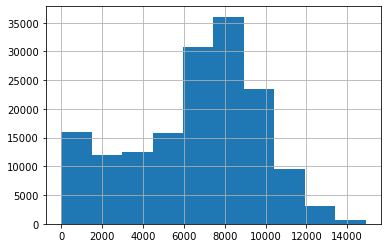

In [12]:
output_df.TWSO.hist()

In [13]:
output_df

,DVS,LAI,TAGP,TWSO,TWLV,TWST,TWRT,TRA,RD,SM,WWLOW,SIM,SIM_DATE
2009-07-19,2.0,0.187508,1257.319549,824.805657,125.728193,306.785699,38.112757,0.044782,60.4,0.187562,39.248721,DAYMET_9584_12_00,2009-04-25
2009-07-29,2.0,0.869449,6212.671923,4172.032321,665.027633,1375.611970,226.239781,0.178391,60.4,0.160542,37.616755,DAYMET_9584_12_00,2009-05-05
2009-08-09,2.0,1.179111,9650.433178,5949.931473,1181.353217,2519.148488,414.896200,0.109723,61.6,0.120473,35.101107,DAYMET_9584_12_00,2009-05-15
2009-08-19,2.0,0.479078,3811.380844,2587.204424,332.232203,891.944217,96.338598,0.100286,61.6,0.163740,37.766359,DAYMET_9584_12_00,2009-05-25
2009-08-29,2.0,1.218765,6745.349759,3755.388953,854.721472,2135.239334,240.559637,0.210431,61.6,0.216011,40.986302,DAYMET_9584_12_00,2009-06-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-11-11,2.0,4.986702,26448.557645,11589.726459,5904.198485,8954.632701,2538.459437,0.373374,75.0,0.166999,37.524898,DAYMET_9584_34_39,2018-06-14
2018-11-22,2.0,3.945924,26711.286821,11114.337573,6416.715502,9180.233746,2717.128738,0.022344,75.0,0.145286,35.896420,DAYMET_9584_34_39,2018-06-24
2018-12-02,2.0,3.456510,25810.399224,10028.149721,6647.261058,9134.988445,2844.521418,0.222898,75.0,0.122237,34.167756,DAYMET_9584_34_39,2018-07-04
2018-12-12,2.0,3.430652,23006.913774,9712.720177,5141.422431,8152.771166,1934.220367,0.035518,75.0,0.103554,32.766574,DAYMET_9584_34_39,2018-07-14
